# Reconstruction du noyau
## Régularisation par Laplacien

Ici la régularisation utilisée pour la reconstruction du noyau est le Laplacien 2D.

In [1]:
import numpy as np
import os
from PIL import Image
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
%matplotlib inline
# Local import
from dataprocess import DataLoader, Blurr, Add_noise
from estimator import Estimator_Lap
from posttreat import Display
from posttreat import Error_Display

##### Kernel

In [2]:
M         = 20
Nx, Ny    = np.meshgrid(np.linspace(-1,1,2*M), np.linspace(-1,1,2*M))
d         = np.sqrt(Nx*Nx+Ny*Ny)
sigma, mu = 0.1, 0.0
K         = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
K         = K/K.sum()

##### Image

In [3]:
file_name = 'Images'
im_name   = 'image05.jpg'
x_i       = DataLoader(file_name,im_name)
# Taille de l'image
x_i  = x_i[:-1,:-1]
print("Taille de l'image :")
x_i = x_i/np.linalg.norm(x_i)
x_i.shape

Taille de l'image :


(320, 480)

In [4]:
x_b  = Blurr(x_i,K)
x_o1 = Add_noise(x_b)
x_o2 = Add_noise(x_b, noise_level = 0.1)

##### Laplacian of an image (test)

In [5]:
# Derivation
m,n    = x_i.shape
d      = -np.ones((3,3))
d[1,1] = 8
d_pad  = np.zeros(x_i.shape)
d_pad[m//2:m//2+3,n//2:n//2+3] = d

In [6]:
def myconvolv(a,b):
    # a and b must be of same size !
    m,n   = a.shape
    # Perform fft
    fft_a = fft2(a)
    fft_b = fft2(b)
    # Compute multiplication and inverse fft
    cc    = np.real(ifft2(fft_a*fft_b))
    cc    = fftshift(cc)
    return cc

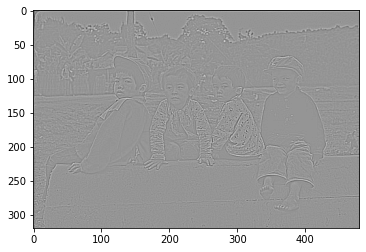

In [7]:
dx = myconvolv(d_pad,x_i)
plt.imshow(dx,cmap="gray")

##### Test du gradient
On teste que le gradient de la fonction 
$
f(x) = \| d \circledast x\|^2
$
est bien
$$
\nabla f (x) = 2 \bar{d} \circledast d \circledast x
\; ,
$$
où $\bar{d}$ est le symétrisé de $d$.

In [8]:
def f(x):
    f = np.linalg.norm(myconvolv(d_pad,x))**2
    return f

In [9]:
def gradf(x,h):
    fftx = fft2(x)
    fftd = fft2(d_pad)
    # multiplication dans l'espace de Fourier
    fftg = 2*np.conjugate(fftd)*fftd*fftx
    # transformée inverse
    cc = np.real(ifft2(fftg))
    cc = fftshift(cc) # attention la fréquence zéro doit être remise au centre
    gradf = np.sum(cc*h)
    return gradf

In [10]:
h = np.random.randn(m,n)
h = h/np.linalg.norm(h)
gradf(x_i,h)

0.017325476148129067

In [11]:
f(x_i+h)-f(x_i)

71.9902447756332

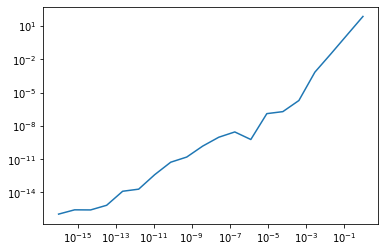

In [12]:
nsamples = 20
hnorm    = np.logspace(-16,0,nsamples)
error    = np.zeros(nsamples)
i        = 0
for t in hnorm:
    h = np.random.randn(m,n)
    h = t*h/np.linalg.norm(h)
    grad1 = f(x_i+h)-f(x_i)
    grad2 = gradf(x_i,h)
    error[i] = abs(grad1-grad2)
    i+=1
plt.loglog(hnorm,error)

##### Reconstruction

On souhaite minimiser la fonction,
$$
J(x) =\alpha\| d \circledast x\|^2 +\mu \| x \circledast x_{init} - x_{blurred} \|^2 
\; .
$$
où $d$ est la petite matrice de laplacien
$$
d= \begin{pmatrix}
-1 & -1 & -1 \\
-1 &  8 & -1 \\
-1 & -1 & -1 \\
\end{pmatrix}
\; .
$$

On se place dans le domaine de Fourier pour traiter les convolutions,
$$
J(x) = \alpha\| \hat{d}\hat{x}\| +\mu\| \hat{x}\hat{x}_{init} - \hat{x}_{blurred} \|^2 
\; .
$$

On choisit l'algorithme de descente de gradient (méthode naïve)
$$
\begin{cases}
\text{initialisation} \\
\hat{x}_0 , \hat{xi},\hat{xb}, \hat{d}\\
\\
\text{itération}\; \; 0 \leq k \leq N\\
\text{grad} = 2\alpha \hat{d} \hat{d} \hat{x}_k
             + 2\mu \hat{xi}(\hat{xi}\hat{x}_k -\hat{xb}) \\
 \\
\hat{x}_{k+1} = \hat{x}_k - \tau \text{grad} \\
\\
\text{transformée inverse} \\
x_{end} = \text{ifft}(\hat{x}_N)
\end{cases}
$$

In [13]:
alpha = 1
mu    = 1
K_alpha = Estimator_Lap(M,x_i,x_b,alpha,mu,tau=0.1,niter = 5000)

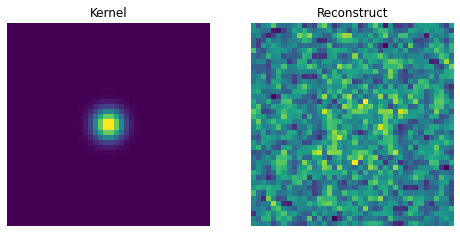

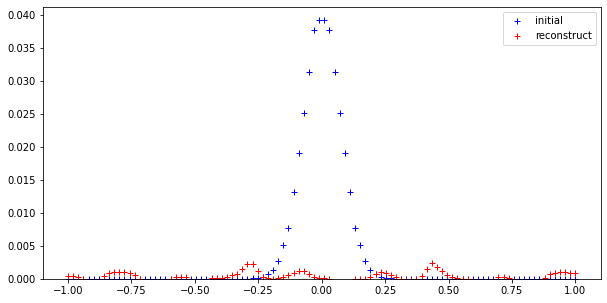

In [14]:
Display(K,K_alpha)